# Cross Validation of NMF

Perform cross-validation for NMF.

In [234]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

sns.set("talk", "ticks", palette='colorblind')

# Set the default paths
basepath = Path(os.path.dirname(os.path.realpath('__file__')))
datapath = basepath.parent.joinpath('data/munged')

print (datapath)

/home/hagan_2019a_estl/data/munged


## Write the Nonnegative Matrix Factorization Code that can handle missing data

In [414]:
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:, None]
        
    rhs = np.dot(A.T, M * B).T[:, :, None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    
    return X.T

def cv_nmf(data, rank, M=None, p_holdout=0.3, tol=0.001, verbose=False, max_iter=50):
    """Perform cross-validation for NMF using a speckled holdout pattern.
    
    This code was adapted from Alex Williams at Stanford (https://bit.ly/2KDqKoW).
    
    Args
    ----
    data (ndarray)    : m x n matrix (original data/time-series)
    rank (int)        : the desired output rank (i.e. number of factors)
    M (ndarray)       : m x n binary matrix where zeroes indicate missing/heldout values 
    p_holdout (float) : all random data under this value will be set to False
    tol (float)       : the tolerance for convergence - the solution has converged when 
                        the MSE of subsequent iterations are less than this number
    verbose (bool)    : if True, print out debugging information
    max_itr (int)     : the maximum number of iterations for convergence
    
    Returns
    -------
    U (ndarray)       : 
    Vt (ndarray)      :
    train_err (float) :
    test_err (float)  :
    converged (bool)  :
    
    """   
    # create the masking matrix to decide which values to "hold out"
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout
        
        # check to make sure there are enough values in each row to avoid singular matrix issues
        if M.sum(axis=0).any() < rank:
            for i in range(M.shape[0]):
                if M[i].sum() < rank:
                    M[i, :] = [True]*M.shape[1]
    
    # initialize U randomly
    U = np.random.rand(data.shape[0], rank)

    # init the mean err
    mse = 100
    
    # fit NMF
    for itr in range(max_iter):
        Vt = censored_nnlstsq(U, data, M)
        U = censored_nnlstsq(Vt.T, data.T, M.T).T
        
        # calculate the current iterations mean squared error
        tmp_mse = np.mean((np.dot(U, Vt) - data)**2)
        diff = mse - tmp_mse
          
        # break out of the loop if converged
        if abs(diff) <= tol:
            converged = True
            break
        else:
            mse = tmp_mse
            converged = False
    
    if verbose:
        train_pct = 100 * M.sum() / M.size
        print ("\tIter {} = {:.5f}".format(itr+1, diff))
        print ("\tTrain/Test = {:.2f}/{:.2f}".format(train_pct, 100-train_pct))
        
    # return the result and the train/test error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
        
    return U, Vt, train_err, test_err, converged

### Let's try an example...

In [372]:
N, R = 150, 4

noise = 0.8
replicates = 10

ranks = np.arange(1, 6)

# initialize the problem
U = np.random.rand(N, R) # (150, 4)
Vt = np.random.rand(R, N) # (4, 150)

# create the data by making it noisy
data = np.dot(U, Vt) + noise * np.random.rand(N, N) # (150, 150)

frame = pd.DataFrame()

# fit the models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te, converged = cv_nmf(data, rnk, verbose=False)[2:]
    
    if converged:
        frame = frame.append([
            {"Rank": rnk, "MSE": tr, "Group": "Train"},
            {"Rank": rnk, "MSE": te, "Group": "Test"},
        ], ignore_index=True)
    else:
        print ("there was a convergence issue: {}".format(rnk))
        
frame["Rank"] = frame["Rank"].astype(np.int32)

# prepare for plotting
groups = frame.groupby(["Group", "Rank"]).describe(percentiles=[0.05, 0.95])

### Plot the results

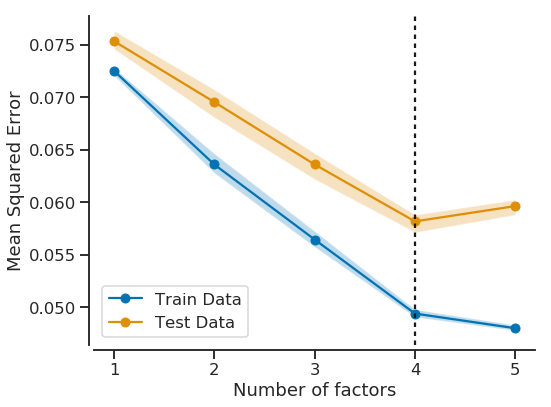

In [373]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.plot(groups["MSE"]["mean"]["Train"], 'o-', label="Train Data")
ax.plot(groups["MSE"]["mean"]["Test"], 'o-', label="Test Data")

ax.fill_between(groups["MSE"]["5%"]["Train"].index, groups["MSE"]["5%"]["Train"], 
                groups["MSE"]["95%"]["Train"], alpha=0.25)
ax.fill_between(groups["MSE"]["5%"]["Test"].index, groups["MSE"]["5%"]["Test"],
                groups["MSE"]["95%"]["Test"], alpha=0.25)

inflection = (groups["MSE"]["mean"]["Test"] > groups["MSE"]["mean"]["Test"].shift()).idxmax() - 1

ax.axvline(inflection, color='k', dashes=[2, 2])

sns.despine(offset=5)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Number of factors")
ax.legend()
plt.tight_layout()

fig.savefig("Example 4 Factor Solution.png", dpi=350)

## The fun part - Let's try this on our India Data

In [491]:
df = pd.read_feather(datapath.joinpath("tata2017015/final-data.feather")).set_index("index")

COLS_TO_INCLUDE = ['co', 'no2', 'o3', 'so2', 'bin0', 'bin1', 'bin2']

df = df.dropna(subset=COLS_TO_INCLUDE)[COLS_TO_INCLUDE].sample(frac=0.15)

df = df / df.max().max()

df.head(2)

,co,no2,o3,so2,bin0,bin1,bin2
index,,,,,,,
2018-01-27 20:17:00+05:30,0.224836,0.009913,0.003871,0.010734,0.089512,0.042703,0.030385
2018-01-23 16:28:00+05:30,0.118724,0.006628,0.003519,0.008271,0.109397,0.040533,0.019298


In [492]:
replicates = 3

ranks = np.arange(1, 6)

frame = pd.DataFrame()

# fit the models
for rnk, j in itertools.product(ranks, range(replicates)):
    print ("Rank {}.{}".format(rnk, j))
    
    tr, te, converged = cv_nmf(df.values, rnk, verbose=True, tol=1e-4, max_iter=150, p_holdout=0.24)[2:]
    
    if not converged:
        print ("there was a convergence issue: {}".format(rnk))
    frame = frame.append([
        {"Rank": rnk, "MSE": tr, "Group": "Train", "Converged": converged},
        {"Rank": rnk, "MSE": te, "Group": "Test", "Converged": converged},
    ], ignore_index=True)

frame["Rank"] = frame["Rank"].astype(np.int32)

# prepare for plotting
groups = frame.groupby(["Group", "Rank"]).describe(percentiles=[0.05, 0.95])

Rank 1.0
	Iter 2 = -0.00009
	Train/Test = 76.39/23.61
Rank 1.1
	Iter 3 = -0.00010
	Train/Test = 75.96/24.04
Rank 1.2
	Iter 4 = -0.00004
	Train/Test = 75.64/24.36
Rank 2.0
	Iter 3 = -0.00003
	Train/Test = 76.07/23.93
Rank 2.1
	Iter 3 = -0.00001
	Train/Test = 76.12/23.88
Rank 2.2
	Iter 4 = -0.00005
	Train/Test = 75.95/24.05
Rank 3.0
	Iter 3 = 0.00002
	Train/Test = 76.72/23.28
Rank 3.1
	Iter 3 = -0.00001
	Train/Test = 76.76/23.24
Rank 3.2
	Iter 4 = -0.00001
	Train/Test = 76.77/23.23
Rank 4.0
	Iter 3 = 0.00001
	Train/Test = 79.52/20.48
Rank 4.1
	Iter 3 = -0.00005
	Train/Test = 79.73/20.27
Rank 4.2
	Iter 4 = 0.00004
	Train/Test = 79.22/20.78
Rank 5.0
	Iter 3 = 0.00009
	Train/Test = 86.65/13.35
Rank 5.1
	Iter 3 = 0.00009
	Train/Test = 86.40/13.60
Rank 5.2
	Iter 4 = 0.00000
	Train/Test = 86.61/13.39


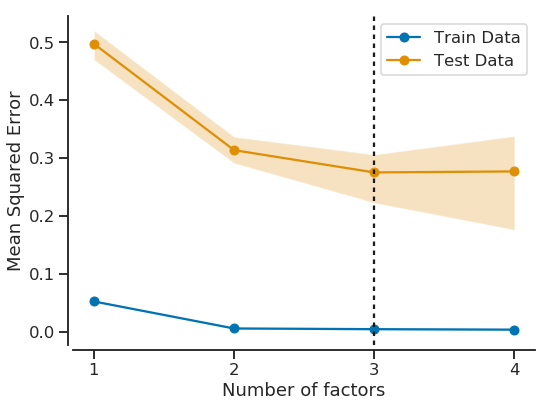

In [504]:
fig, ax = plt.subplots(1, figsize=(8, 6))

scalar = 100

ax.plot(groups["MSE"]["mean"]["Train"][:-1]*scalar, 'o-', label="Train Data")
ax.plot(groups["MSE"]["mean"]["Test"][:-1]*scalar, 'o-', label="Test Data")

ax.fill_between(groups["MSE"]["5%"]["Train"].index[:-1], groups["MSE"]["5%"]["Train"][:-1]*scalar, 
                groups["MSE"]["95%"]["Train"][:-1]*scalar, alpha=0.25)
ax.fill_between(groups["MSE"]["5%"]["Test"].index[:-1], groups["MSE"]["5%"]["Test"][:-1]*scalar,
                groups["MSE"]["95%"]["Test"][:-1]*scalar, alpha=0.25)

inflection = (groups["MSE"]["mean"]["Test"] > groups["MSE"]["mean"]["Test"].shift()).idxmax() - 1

ax.axvline(inflection, color='k', dashes=[2, 2])

sns.despine(offset=5)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Number of factors")
ax.legend()
plt.tight_layout()

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels([1, 2, 3, 4])

fig.savefig("India CV Solution.final.png", dpi=350)